## Practical Exercise 1: word2vec
By Joline Janz and Frederik Wollatz

Each Notebook will contribute equaly to your final grade.

This practical Exercise is presented as an IPython Notebook, with the code written for recent versions of **Python 3**. 

To execute a notebook cell, press `shift-enter`. The return value of the last command will be displayed, if it is not `None`.

Potentially useful library documentation, references, and resources:

* IPython notebooks: <https://ipython.org/ipython-doc/3/notebook/notebook.html#introduction>
* Numpy numerical array library: <https://docs.scipy.org/doc/>
* Gensim's word2vec: <https://radimrehurek.com/gensim/models/word2vec.html>
* Bokeh interactive plots: <http://bokeh.pydata.org/en/latest/> (we provide plotting code here, but click the thumbnails for more examples to copy-paste)
* scikit-learn ML library (aka `sklearn`): <http://scikit-learn.org/stable/documentation.html>
* nltk NLP toolkit: <http://www.nltk.org/>
* tutorial for processing xml in python using `lxml`: <http://lxml.de/tutorial.html> (we did this for you below, but in case you need it in the future)

In this Notebook you will learn the basics on how to construct a word-embedding. As you recall from the lecture, word-embeddings are a type of word representation that allows words with similar meaning to have a similar representation. To do this, words are represented as real-valued vectors in a predefined vector space. Additionally, you will also learn how to use some basic NLP tools like tokenization and regular Expressions!
Good Luck!

In [1]:
import numpy as np
import os
from random import shuffle
import re
import nltk

In [2]:
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [5]:
try: 
    import nltk
except:
    import sys #Here we install nltk. You only have to execute this cell once!
    !{sys.executable} -m pip install nltk 
    import nltk
    nltk.download()

In [4]:
import nltk
nltk.download('all')

[nltk_data] Error loading all: <urlopen error [Errno 8] nodename nor
[nltk_data]     servname provided, or not known>


False

### Part 0: Load the TED dataset

As input we need a large amount of text data. We will use the TED database, which are the transcripts of Ted Talks.

In [6]:
import zipfile
import lxml.etree

In [7]:
# Upload the dataset if it's not already there: this may take a minute as it is 75MB
if not os.path.isfile('ted_en-20160408.zip'):
  from google.colab import files
  # select the file "ted_en-20160408.zip" from your local drive here
  uploaded = files.upload()

In [8]:
# For now, we're only interested in the subtitle text, so let's extract that from the XML:
with zipfile.ZipFile('ted_en-20160408.zip', 'r') as z:
    doc = lxml.etree.parse(z.open('ted_en-20160408.xml', 'r'))
input_text = '\n'.join(doc.xpath('//content/text()'))
del doc

### Part 1: Preprocessing

Before using our text, we need to preprocess it. Therefore, we bring it into a form that is predictable and analyzable. We attempt to clean up the raw subtitles a bit, so that we get only complete sentences. The following substring shows examples of what we're trying to get rid of. Since it's hard to define precisely what we want to get rid of, we'll just use some simple heuristics.

<h4>Execercise 1.1 (2 Points)</h4> 
Before we work with the data we should have a look at it. We already marked some areas for you, that need to be cleaned. You do not have to code anything here, you just have to become aware of sensitive preprocessing steps.

In [25]:
#Have a look at the output of this code, to see some examples
i = input_text.find("Hyowon Gweon: See this?")
print(input_text[i:i+145])


i = input_text.find("You will earn")
print(input_text[i:i+30])

Hyowon Gweon: See this? (Ball squeaks) Did you see that? (Ball squeaks) Cool. See this one? (Ball squeaks) Wow.
Laura Schulz: Told you. (Laughs)

You will earn 10% of any gold 


For example the parenthesized strings like "(Ball squeaks)" and symbols like % could have a negative impact on the word embeddings. Name at least two more problematic sections and how you would solve them.


<b>Your Solution:</b> 
<br>- Parenthesized Strings
<br>- Percent-Symbol
<br>- numbers
<br>- non-letters


<h4>Exercise 1.2 (2 Points)</h4>
Let's start by removing all parenthesized strings using a regex:

In [26]:
i = input_text.find("Hyowon Gweon: See this?")
print("before")
print(input_text[i:i+93])

input_text_noparens = re.sub(r'\([^)]*\)', '', input_text) #Identifies everything in parenthesis and replaces it with ""


#you can use this to verify
i = input_text_noparens.find("Hyowon Gweon: See this?")
print("after")
print(input_text_noparens[i:i+93])

#We won't worry about the irregular spaces since we'll later split the text into sentences and tokenize it anyway.

before
Hyowon Gweon: See this? (Ball squeaks) Did you see that? (Ball squeaks) Cool. See this one? (
after
Hyowon Gweon: See this?  Did you see that?  Cool. See this one?  Wow.
Laura Schulz: Told you.


Try it yourself: Replace every percentage Symbol with the word "percent"

In [27]:
i = input_text_noparens.find("You will earn")
print("before")
print(input_text_noparens[i:i+30])

#Your implementation goes here!
input_text_clean = re.sub(r'%', ' percent', input_text) #Identifies every % symbol and replaces it with ""


i = input_text_clean.find("You will earn")
print("after")
print(input_text_clean[i:i+37])

before
You will earn 10% of any gold 
after
You will earn 10 percent of any gold 


<h4>Exercise 1.3 (4 Points)</h4>
Now you have learned how to use RegEx to your advantage and have Identified potential parts of the text, that we want to eliminate. We have already implented how to remove all parenthesized strings. Now we want to replace every number in the text with its respectiv string. E.g. 10 -> ten ; 
42 -> forty-two


In [28]:
#!pip install num2words
from num2words import num2words

i = input_text_clean.find("You will earn") #find problematic parts
print("before")
print(input_text_clean[i:i+37]) #and show them
print(type(input_text_clean))

#Your implementation here
all_numbers_in_digits = re.findall("[0-9]+", input_text_clean)
all_numbers_in_text = {number:num2words(number) for number in all_numbers_in_digits}
def number_to_word(matchobj):
    return all_numbers_in_text[matchobj.group(0)]
input_text_clean = re.sub(r"[0-9]+", number_to_word, input_text_clean )

i = input_text_clean.find("You will earn") #validate your method
print("after")
print(input_text_clean[i:i+37])

before
You will earn 10 percent of any gold 
<class 'str'>
after
You will earn ten percent of any gold


<h4>Exercise 1.4 (4 Points)</h4>
What does this block of code do? Identify one possible flaw. You dont have to code anything here!


In [29]:
i = input_text_clean.find("Hyowon Gweon: See this?")
print("before:")
print(input_text_clean[i-50:i+92])
precolons = []
lines = []
postcolons = []

X = []
for line in input_text_clean.split('\n'): #take each line of input_text_clean, because we split it at each linebreak
    #print("line: ", line)
    lines.append(line)
    m = re.match(r'^(?:(?P<precolon>[^:]{,20}):)?(?P<postcolon>.*)$', line)
    #assert m.groupdict()["precolon"] == None, "something"
    precolons.append(m.groupdict()["precolon"])
    #print("precolon ", m.groupdict()["precolon"])
    #print("postcolon ", m.groupdict()['postcolon'])
    postcolons.append(m.groupdict()['postcolon'])
    #assert m.groupdict()["postcolon"] == line, "something else"
    X.extend(m.groupdict()['postcolon'])
input_text_clean2="".join(X)

i = input_text_clean2.find("See this?")
print("after:")
print(input_text_clean2[i-50:i+92])

before:
k them. But let's see what the baby does.
(Video) Hyowon Gweon: See this? (Ball squeaks) Did you see that? (Ball squeaks) Cool. See this one? 
after:
 or whack them. But let's see what the baby does. See this? (Ball squeaks) Did you see that? (Ball squeaks) Cool. See this one? (Ball squeaks)


Your Answer goes here!
1. ^ - matches the start of the string
2. (?:...) - matches whatever regular expression is inside, but pattern cannot be retrieved after performing match
3. ?P<precolon> - makes the retrieved pattern accesible in dict under key in <..>
4. [^:]{,20} - matches up to 20 characters except :
5. .* - . matches all characters except a new line and * matches 0 or more repitions of RE
All in all the regular expression matches 20 characters before the ":", which corresponds to the person who says the specific sentence. The second part of the regular expression corresponds to the rest of the line, which a complete sentence.

One possible flaw would be that the precolon can only be 20 characters long, maybe the whole speakers name won't be fully matched.
Maybe this code is computationally more expensive than re.sub. With re.sub we can simiply delete the precolon part instead of adding postcolon to a list which adds one more step of computation.

<h4>Exercise 1.5 (6 Points)</h4>

To build our embedding we need to tokenize every single word. Therefore we first need to split the text into sentences and after that into words. 
Try it yourself or use the NLTK-Tools build for this (https://www.kite.com/python/docs/nltk.word_tokenize + https://www.kite.com/python/docs/nltk.sent_tokenize).
To make it easier to build our Embedding we should also delete every character that is not a letter. Additionally, we could lower vocabulary count. A way to do this is by converting capital characters to lower case characters.

Split your text into sentences and save them in the array `sentences_strings_ted`.
Save one variabale `tokens` with all the tokens in the text and one array named `sentences_ted` that contains an array for every sentence, with all the tokenized words of that sentence.<br><br>
Example:<br>
If the Text looks like this: "I love cake. You have to be honest, you love it too!", the variables look like:<br><br>
sentences_strings_ted=['I love cake.', 'You have to be honest, you love it too!']<br>
sentences_ted=[['i', 'love', 'cake'], ['you', 'have', 'to', 'be', 'honest', 'you', 'love', 'it', 'too']]<br>
tokens=['i', 'love', 'cake', 'you', 'have', 'to', 'be', 'honest', 'you', 'love', 'it', 'too']<br>


Apply this to `input_text_clean`

In [30]:
input_text_clean_letters = re.sub(r"\W^.", "", input_text_clean )
# This gets rid of all non-word characters at the beginning of a string -- TODO do we want to keep this? Its not doing the full job

In [31]:
input_text_clean_lower = input_text_clean_letters.lower()

In [14]:
#print(input_text_clean_lower[:10000])

In [35]:
sentences_strings_ted = nltk.tokenize.sent_tokenize(input_text_clean_lower)
#print(sentences_strings_ted)




In [37]:
with open('sentences_strings_ted.txt', 'w+') as f:
    # write elements of list
    for items in sentences_strings_ted:
        f.write('%s\n' %items)

    print("File written successfully")
# close the file
f.close()

File written successfully


In [62]:
sentences_strings_ted_clean = [re.sub(r"[(),.:;'-?]", "", string) for string in sentences_strings_ted]
# Insight: if I remove all non-letters before sent_tokenize doesn't recognize the individual sentences. If I don't, it does.
# Ideally we should then remove them after the sent_tokenization
#print(sentences_strings_ted_clean)

In [63]:
print(sentences_strings_ted_clean[:10])

['here are two reasons companies fail they only do more of the same or they only do whats new', 'to me the real real solution to quality growth is figuring out the balance between two activities exploration and exploitation', 'both are necessary but it can be too much of a good thing', 'consider facit', 'im actually old enough to remember them', 'facit was a fantastic company', 'they were born deep in the swedish forest and they made the best mechanical calculators in the world', 'everybody used them', 'and what did facit do when the electronic calculator came along', 'they continued doing exactly the same']


In [64]:
sentences_ted = [nltk.word_tokenize(sentence) for sentence in sentences_strings_ted_clean]


In [65]:
print(sentences_ted[:10])

[['here', 'are', 'two', 'reasons', 'companies', 'fail', 'they', 'only', 'do', 'more', 'of', 'the', 'same', 'or', 'they', 'only', 'do', 'whats', 'new'], ['to', 'me', 'the', 'real', 'real', 'solution', 'to', 'quality', 'growth', 'is', 'figuring', 'out', 'the', 'balance', 'between', 'two', 'activities', 'exploration', 'and', 'exploitation'], ['both', 'are', 'necessary', 'but', 'it', 'can', 'be', 'too', 'much', 'of', 'a', 'good', 'thing'], ['consider', 'facit'], ['im', 'actually', 'old', 'enough', 'to', 'remember', 'them'], ['facit', 'was', 'a', 'fantastic', 'company'], ['they', 'were', 'born', 'deep', 'in', 'the', 'swedish', 'forest', 'and', 'they', 'made', 'the', 'best', 'mechanical', 'calculators', 'in', 'the', 'world'], ['everybody', 'used', 'them'], ['and', 'what', 'did', 'facit', 'do', 'when', 'the', 'electronic', 'calculator', 'came', 'along'], ['they', 'continued', 'doing', 'exactly', 'the', 'same']]


In [66]:
#print(sentences_ted[:10])
tokens = [string for sentences in sentences_ted for string in sentences]
print(tokens[:100])

['here', 'are', 'two', 'reasons', 'companies', 'fail', 'they', 'only', 'do', 'more', 'of', 'the', 'same', 'or', 'they', 'only', 'do', 'whats', 'new', 'to', 'me', 'the', 'real', 'real', 'solution', 'to', 'quality', 'growth', 'is', 'figuring', 'out', 'the', 'balance', 'between', 'two', 'activities', 'exploration', 'and', 'exploitation', 'both', 'are', 'necessary', 'but', 'it', 'can', 'be', 'too', 'much', 'of', 'a', 'good', 'thing', 'consider', 'facit', 'im', 'actually', 'old', 'enough', 'to', 'remember', 'them', 'facit', 'was', 'a', 'fantastic', 'company', 'they', 'were', 'born', 'deep', 'in', 'the', 'swedish', 'forest', 'and', 'they', 'made', 'the', 'best', 'mechanical', 'calculators', 'in', 'the', 'world', 'everybody', 'used', 'them', 'and', 'what', 'did', 'facit', 'do', 'when', 'the', 'electronic', 'calculator', 'came', 'along', 'they', 'continued']


<h4>Exercise 1.6 (1 Point)</h4>
The good side is, that by converting all capital letters is, we reduce the volume of the vocabulary. Thereby we dont differentiate between the the words "today" and "Today". 
Can you think of any downside to this process?

YOUR ANSWER GOES HERE

Now we can have a look at the processed dataset:

In [67]:
len(sentences_ted)

273205

In [68]:
print(sentences_ted[0])
print(sentences_ted[-1])

['here', 'are', 'two', 'reasons', 'companies', 'fail', 'they', 'only', 'do', 'more', 'of', 'the', 'same', 'or', 'they', 'only', 'do', 'whats', 'new']
['applause']


### Part 2: Word Frequencies

<h4>Exercise 2.1 (4 Points)</h4>
Your next task will be to store the counts of the top 1000 most frequent words in a list called `counts_ted_top1000` ! There are multiple ways to do this. You can have a look at the Counter-Function(https://docs.python.org/2/library/collections.html) or the FreqDist-Function (https://www.kite.com/python/docs/nltk.FreqDist). If you dont trust any of those you can of course build your own function.
In the end we want an array with tupels of the structure [(WordA,FrequencyA),(WordB,FrequencyB)].

In [69]:
#Your Code here
counts_ted_top1000 = nltk.FreqDist(tokens)
counts_ted_top1000_sorted = {key: val for key, val in sorted(counts_ted_top1000.items(), key = lambda ele: ele[1], reverse = True)}
counts_ted_top1000tupels = [(key, value) for key, value in zip(counts_ted_top1000_sorted.keys(), counts_ted_top1000_sorted.values())]
print(counts_ted_top1000tupels[:100])

# TO_DO Exclude non-words???

[('the', 207759), ('and', 155084), ('to', 124889), ('of', 114750), ('a', 104974), ('that', 84752), ('in', 77905), ('i', 67872), ('is', 63313), ('you', 62695), ('we', 56255), ('it', 52469), ('this', 49275), ('so', 36930), ('was', 30808), ('for', 29675), ('are', 28004), ('have', 27353), ('but', 26747), ('they', 26732), ('on', 25833), ('its', 24885), ('with', 24719), ('what', 24221), ('one', 21737), ('can', 21488), ('about', 21249), ('be', 20190), ('as', 19518), ('not', 19309), ('at', 19227), ('all', 18891), ('my', 17936), ('do', 17904), ('``', 17276), ("''", 17257), ('were', 16780), ('people', 16289), ('like', 16047), ('if', 15867), ('from', 15458), ('there', 15153), ('now', 14387), ('our', 14066), ('an', 13917), ('just', 13897), ('these', 13881), ('or', 13843), ('when', 13271), ('because', 12882), ('very', 12368), ('me', 12296), ('out', 12048), ('he', 12045), ('by', 11868), ('them', 11594), ('how', 11542), ('know', 11488), ('going', 11364), ('up', 11130), ('had', 10910), ('more', 10907)

The following code is going to plot a histogramm of the distribution of the  top-30 words.

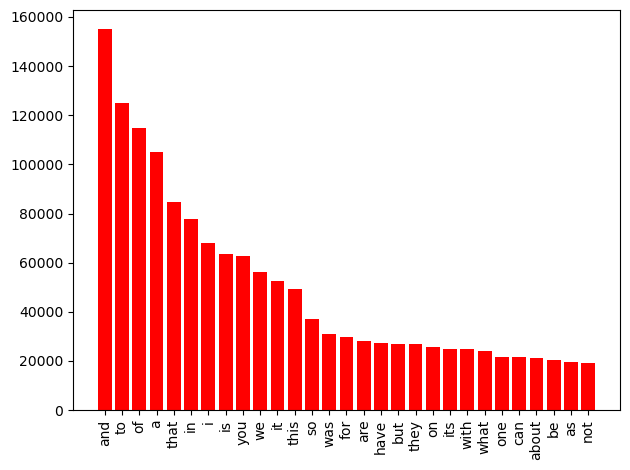

In [70]:
import matplotlib.pyplot as plt
mostfreqn=30 #Here we define how many of them we want to see in the diagramm 

# we exclude the first element of the list since this the empty string we used to replace all non-words.
frequency=[y for (x,y) in counts_ted_top1000tupels][1:mostfreqn]
word=[x for (x,y) in counts_ted_top1000tupels][1:mostfreqn]
indices = np.arange(len(counts_ted_top1000tupels[1:mostfreqn]))
plt.bar(indices, frequency, color='r')
plt.xticks(indices, word, rotation='vertical')
plt.tight_layout()
plt.show()

You can clearly see, that many of the most common words are so called stop words. Stop Words are words, that are tipically not usefull to identify what a text is about.

### Part 3: Train Word2Vec

Now it is time to train the modell. Gensim has an already implemented model that you can use.

Using the provided modell is enough for the purposes of our notebook. If you want to dive deeper into the topic this youtube video https://www.youtube.com/watch?v=kKDYtZfriI8 could be a great guidance for you to get started. 


In [71]:
#This takes a moment...dont worry :D
from gensim.models import Word2Vec
model_ted = Word2Vec(sentences_ted)

### Part 4: Ted Learnt Representations (3 Points)


Finding similar words: (see gensim docs for functions, that might help you https://radimrehurek.com/gensim/models/keyedvectors.html)

Now lets explore what we can do with this! How does "house" look in our embedding?

In [32]:
#from gensim.models import KeyedVectors
#word_vectors = KeyedVectors.load('vectors.kv')

In [72]:
#YOUR CODE
word_vectors = model_ted.wv

In [73]:
house = word_vectors["house"]
print(house)

[-0.65089786 -0.79816306  0.7783218   0.39264402 -0.8294586  -1.4521788
  0.2778762   1.2564628   1.7313284   1.6762106   0.7367975   0.8202555
  0.42303273  1.5042094   0.69438434  0.41142446 -0.00954479 -0.39477888
  0.8210256   0.21287572  1.5220025   0.6620833   0.9176902   0.08272233
  0.29598165  0.7940185  -0.39570144  0.00945813  0.16292989 -2.010916
  0.9660226   0.03189266 -0.2389963  -0.39884698 -1.183032   -0.7247808
  0.14593405 -0.87092274 -1.0120122   0.60807955  0.20707758  0.3576644
  0.47455612 -2.0455887   0.2621043   0.50711346 -1.4906403  -0.08332733
  0.51969993  0.359386    0.82902753  0.4485756  -1.1678245  -0.18367831
  1.3154924  -0.02185158  0.37246016  0.546274    0.8753189  -1.3190533
 -0.05383239  0.42007905  0.004351   -0.29443622 -2.9572425   1.9900239
 -0.88712037 -0.48415214 -0.6461691   1.5152043   0.5078734   0.48452333
 -0.41967806 -0.02307892 -0.33725074  0.17125413 -0.8806341  -1.2528064
  1.0063815   0.03879892  0.96225333 -0.02969971 -1.7501395 

In [74]:
word_vectors.save('vectors2.kv')

What is the most similar word for "town"?

In [75]:
#YOUR CODE
similar_to_town = word_vectors.similar_by_word("town")
print(similar_to_town)

[('village', 0.8902608156204224), ('neighborhood', 0.8290932774543762), ('park', 0.8084426522254944), ('house', 0.776294469833374), ('hotel', 0.7675920128822327), ('london', 0.7600166201591492), ('tent', 0.7599292993545532), ('apartment', 0.7583268880844116), ('garden', 0.7495085000991821), ('island', 0.7494161128997803)]


How similar are the words "town" and "house"?

In [76]:
#YOUR CODE
similarity_house_town = word_vectors.similarity("town", "house")

In [77]:
print(similarity_house_town)

0.7762946


<h4>Exercise 4.1 (3 Points)</h4>
Now that we have trained our own embedding, lets test some classical ideas: 
implement the following formula. Print out the 10 words, that are most similar to this formula: <br>
$King-Man+Woman=???$
There are two ways of computing similarity in word Embeddings:
 - https://tedboy.github.io/nlps/generated/generated/gensim.models.Word2Vec.most_similar.html
 - https://tedboy.github.io/nlps/generated/generated/gensim.models.Word2Vec.most_similar_cosmul.html
You should try out both! In this case one of them is better, but both of them are valid methods for computing similarity in the word-space.


In [80]:
#Your Implementation goes here!
man_king_woman1 = word_vectors.most_similar(positive=['king', 'woman'], negative=['man'])
print(man_king_woman1)

[('president', 0.7851525545120239), ('obama', 0.7835389971733093), ('luther', 0.7686629295349121), ('martin', 0.7612045407295227), ('james', 0.7549343109130859), ('french', 0.7520917654037476), ('charles', 0.7352443337440491), ('clinton', 0.7266717553138733), ('john', 0.7227074503898621), ('nelson', 0.7221478819847107)]


In [79]:
man_king_woman2 = word_vectors.most_similar_cosmul(positive=['woman', 'king'], negative=['man'])
print(man_king_woman2)

[('obama', 0.9364627599716187), ('president', 0.9326005578041077), ('luther', 0.9225468039512634), ('martin', 0.9175904393196106), ('french', 0.9152934551239014), ('james', 0.9149983525276184), ('clinton', 0.9063557386398315), ('charles', 0.9043046832084656), ('nelson', 0.9007266759872437), ('barack', 0.8989192247390747)]


<h4>Exercise 4.2 (2 Points)</h4>
The expected outcome (Queen) should be one of the top ten most similar words. But there are also a lot of words, that you would not expect. Think about where how these words might be connected to the formula. Take your time and understand why some of the words (luther, mary, dr, president) might be in this list.

YOUR ANSWER GOES HERE

TODO!!


#### t-SNE visualization

We will use the t-SNE algorithm, given belwo, for visualization. The so-called t-Distributed Stochastic Neighbor Embedding (t-SNE) is an unsupervised and non-linear machine learning technique. It is commonly used for visualizing high dimensional data (just like our high dimensional vectors). You do not have to understand the code, it's purpose is simply to give you an idea of how the data is arranged in high dimensional space.

<h4>Exercise 4.3 (2 Points)</h4>
To use the t-SNE code below, first put a list of the top 100 words (as strings) into a variable `words_top_ted`. 

In [45]:
#Your implementation goes here!
words_top_ted = [word for word, freq in counts_ted_top1000tupels[:100]]
print(words_top_ted)

# This includes not only words but also "(" and ":" -- is that a problem??? TO:DO

[',', '.', 'the', 'and', 'to', 'of', 'a', 'that', 'i', 'in', 'it', 'you', 'we', 'is', "'s", 'this', 'so', 'they', 'was', 'for', 'are', 'have', 'but', 'what', 'do', 'on', 'with', '--', '?', 'one', "n't", 'can', 'about', 'there', 'be', 'as', 'not', 'at', 'all', 'my', "''", '``', 'people', "'re", 'like', 'if', 'from', ')', '(', 'now', 'our', ':', 'he', 'an', 'just', 'these', 'or', 'when', 'because', 'very', 'me', 'out', 'by', 'them', 'how', 'know', 'going', 'up', 'had', 'more', 'would', 'were', 'think', 'who', 'see', 'your', 'their', 'which', 'here', 'really', 'get', "'ve", 'then', 'two', "'m", 'us', 'world', 'some', 'time', 'has', 'laughter', 'could', 'actually', 'into', 'where', 'way', 'hundred', 'did', 'will', 'things']


The following code gets the corresponding vectors from the model, assuming it's called `model_ted`:

In [51]:
# This assumes words_top_ted is a list of strings, the top 250 words --- ???WHY 250??? -> 100?#
words_top_vec_ted = [word_vectors[f"{word}"] for word in words_top_ted]

print(len(words_top_vec_ted))

100


The next few lines are for the t-SNE visualization.

In [47]:
from sklearn.manifold import TSNE 
tsne = TSNE(n_components=2, random_state=0)
words_top_ted_tsne = tsne.fit_transform(words_top_vec_ted)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [48]:
p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="word2vec T-SNE for most common words")

source = ColumnDataSource(data=dict(x1=words_top_ted_tsne[:,0],
                                    x2=words_top_ted_tsne[:,1],
                                    names=words_top_ted))

p.scatter(x="x1", y="x2", size=8, source=source)

labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(labels)

show(p)


# SEEMS FINE